# MultiLingual Text Classification using LSTM, GRU and CNN

## Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
%pip install tensorflow

^C
Note: you may need to restart the kernel to use updated packages.


  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
   ---------------------------------------- 0.0/390.2 MB ? eta -:--:--
   ---------------------------------------- 1.0/390.2 MB 12.5 MB/s eta 0:00:32
   ---------------------------------------- 2.9/390.2 MB 7.0 MB/s eta 0:00:56
    --------------------------------------- 5.2/390.2 MB 9.4 MB/s eta 0:00:42
    --------------------------------------- 6.6/390.2 MB 8.4 MB/s eta 0:00:46
    --------------------------------------- 7.3/390.2 MB 7.7 MB/s eta 0:00:50
    --------------------------------------- 7.9/390.2 MB 6.8 MB/s eta 0:00:56
    --------------------------------------- 8.1/390.2 MB 6.1 MB/s eta 0:01:03
    ---------------

In [4]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import json

# from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Embedding, LSTM, GRU, Conv1D, Dense, GlobalMaxPooling1D, Dropout

In [99]:
def plot_accuracy(epochs, training_history):
    epochs = [i for i in range(1, epochs)]
    plt.plot(epochs,training_history.history['accuracy'],color='red',label='Training Accuracy')
    plt.plot(epochs,training_history.history['val_accuracy'],color='blue',label='Validation Accuracy')
    plt.xlabel('No. of Epochs')
    plt.title('Visualization of Accuracy')
    plt.legend()
    plt.show()

def plot_loss(epochs, training_history):
    epochs = [i for i in range(1, epochs)]
    plt.plot(epochs,training_history.history['loss'],color='red',label='Training Loss')
    plt.plot(epochs,training_history.history['val_loss'],color='blue',label='Validation Loss')
    plt.xlabel('No. of Epochs')
    plt.title('Visualization of Loss')
    plt.legend()
    plt.show()


# Plot confusion matrix
def plot_confusion_matrix(model, X_test, y_test, model_name="model"):
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(20, 20))
    sns.heatmap(cm, annot=True, annot_kws={"size": 15}, cmap='inferno', fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Class',fontsize = 15)
    plt.ylabel('Actual Class',fontsize = 15)
    plt.title(f'Confusion Matrix of {model_name}',fontsize = 15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

def plot_classification_report(model, X_test, y_test, model_name=""):
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    # classification report
    report = classification_report(y_test, y_pred, target_names=class_names)
    print(f"                Classification Report of {model_name} Model\n", report)

## Import dataset

In [5]:
# Load the dataset from CSV file
df = pd.read_csv('/kaggle/input/language-classification-dataset/final_dataset.csv')
df

,Text,language
0,θα σας πείραζε να μου δανείσετε κάποια χρήματα...,Greek
1,இக்கோயில் முதன்மைத் திருக்கோயில் என்ற வகைப்பாட...,Tamil
2,۔ پہ پیښور کې په خپلوں اخراجاتوں د اسمبلیې ممب...,Pushto
3,inför kahnweilers -årsdag publicerades en fest...,Swedish
4,달라란dalaran 마법사들의 국가이며 달라란에 있는 자들은 다들 지식이 방대하며...,Korean
...,...,...
24995,ژوند یې په درې برخو وېشلی شو لومړی اروایي برخه...,Pushto
24996,ತದನಂತರ ಮುಂದುವರಿಯಿರಿ ಮತ್ತು ನೀವು ಎಲ್ಲಿಗೆ ಬಂದಿದ್ದ...,Kannada
24997,родился в москве в детстве занимался борьбой п...,Russian
24998,اردو مېډل زده کړه یې د ډېره غازي خان له جامپور...,Pushto


In [6]:
df.isna().sum()

Text        0
language    0
dtype: int64

In [7]:
df.duplicated().sum()

155

In [8]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

In [9]:
df.shape

(24845, 2)

In [10]:
label_counts = df['language'].value_counts()

# # Print the number of instances of each label
# print("Number of instances of each label:")
# print(label_counts)
label_counts

language
Korean        1000
Urdu          1000
Japanese      1000
Turkish       1000
Romanian      1000
Chinese       1000
Persian       1000
English       1000
Thai          1000
Estonian       999
Russian        999
Arabic         998
Kannada        997
Portugese      997
Spanish        996
Malayalam      996
Dutch          996
Greek          993
Pushto         993
Swedish        992
Hindi          990
French         990
Tamil          981
Indonesian     975
Latin          953
Name: count, dtype: int64

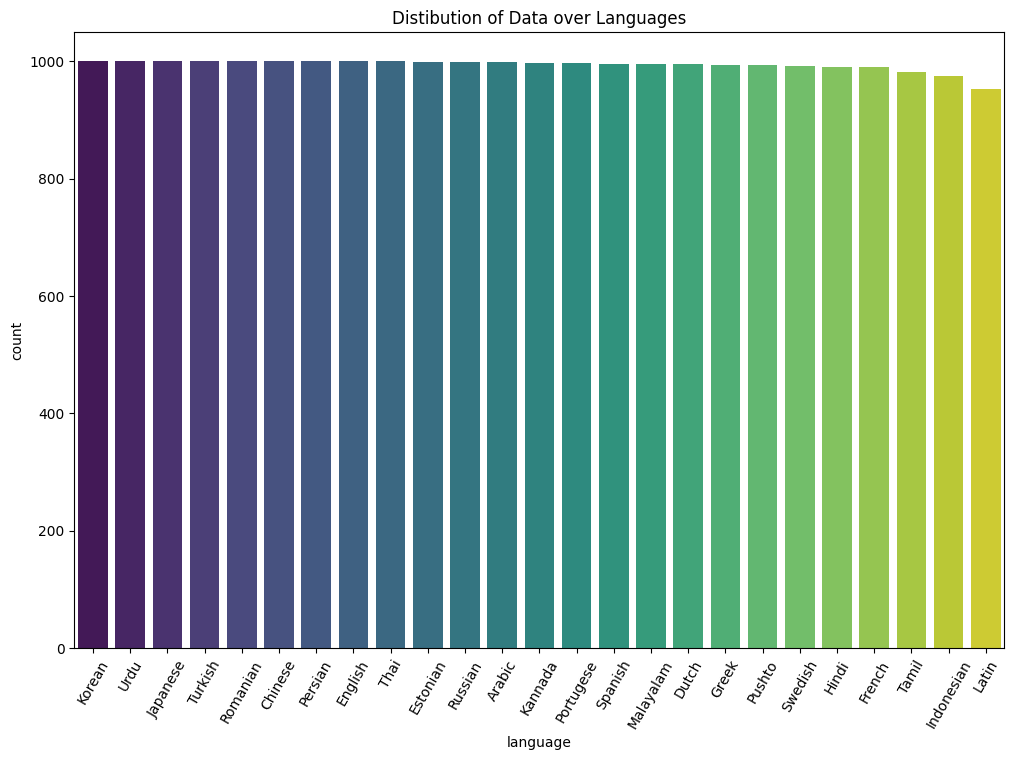

In [11]:
plt.figure(figsize=(12,8))
sns.barplot(data=label_counts.reset_index(), x='language', y='count', palette='viridis')
plt.title("Distibution of Data over Languages")
plt.xticks(rotation=60)
plt.show()

In [12]:
languages = df['language']

label_encoder = LabelEncoder()
label_encoder.fit(languages)
class_names = label_encoder.classes_

class_names

array(['Arabic', 'Chinese', 'Dutch', 'English', 'Estonian', 'French',
       'Greek', 'Hindi', 'Indonesian', 'Japanese', 'Kannada', 'Korean',
       'Latin', 'Malayalam', 'Persian', 'Portugese', 'Pushto', 'Romanian',
       'Russian', 'Spanish', 'Swedish', 'Tamil', 'Thai', 'Turkish',
       'Urdu'], dtype=object)

In [13]:
len(class_names)

25

## Seperate features and target

In [14]:
X = df['Text'].tolist()
y = df['language'].tolist()

# Convert labels to numerical format
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)

# Pad sequences to ensure uniform length
# max_length = max(len(seq) for seq in X)

X = pad_sequences(X, maxlen=100, truncating='post')

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
len(X_train)

19876

In [16]:
vocab_size = len(tokenizer.word_index) + 1

In [17]:
vocab_size

287580

## LSTM Model

In [62]:
Epochs = 20

In [65]:
lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, input_length=100),  
    LSTM(units=64),
    Dropout(0.20),
    Dense(units=25, activation='softmax')
])

lstm_model.build(input_shape=(None, 100))
optimizer = Adam(learning_rate=0.0001)
lstm_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(lstm_model.summary())

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ (None, 100, 100)            │      28,758,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 64)                  │          42,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 25)                  │           1,625 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,801,865 (109.87 MB)

 Trainable params: 28,801,865 (109.87 MB)

 Non-trainable params: 0 (0.00 B)

None


### Train LSTM Model

In [66]:
lstm_training_history = lstm_model.fit(X_train, y_train, epochs=Epochs, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
622/622 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.1256 - loss: 3.0559 - val_accuracy: 0.1644 - val_loss: 2.6986
Epoch 2/20
622/622 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.2657 - loss: 2.5472 - val_accuracy: 0.5442 - val_loss: 1.7993
Epoch 3/20
622/622 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.5710 - loss: 1.6032 - val_accuracy: 0.7456 - val_loss: 1.2687
Epoch 4/20
622/622 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.7475 - loss: 1.0747 - val_accuracy: 0.8223 - val_loss: 0.8949
Epoch 5/20
622/622 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.8270 - loss: 0.7714 - val_accuracy: 0.7631 - val_loss: 0.9916
Epoch 6/20
622/622 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.8574 - loss: 0.6333 - val_accuracy: 0.8825 - val_loss: 0.5935
Epoch 7/20
622/622 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.9036 - loss: 0.4626 - val_accuracy: 0.8821 - val_loss: 0.5068
Epoch 8/20
622/622 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.9239 - loss: 0.3548 - 

### Evaluate LSTM Model

In [67]:
# Evaluate the model on Training set
train_loss, train_acc = lstm_model.evaluate(X_train,y_train)
print('Training Accuracy:', train_acc)
print("Training Loss:", train_loss)

622/622 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9950 - loss: 0.0614
Training Accuracy: 0.9958744049072266
Training Loss: 0.059167712926864624


In [68]:
# Evaluate the model on Test set
val_loss, val_acc = lstm_model.evaluate(X_test,y_test)
print('Validation Accuracy:', val_acc)
print("Validation Loss:", val_loss)

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9053 - loss: 0.3361
Validation Accuracy: 0.902596116065979
Validation Loss: 0.33854249119758606


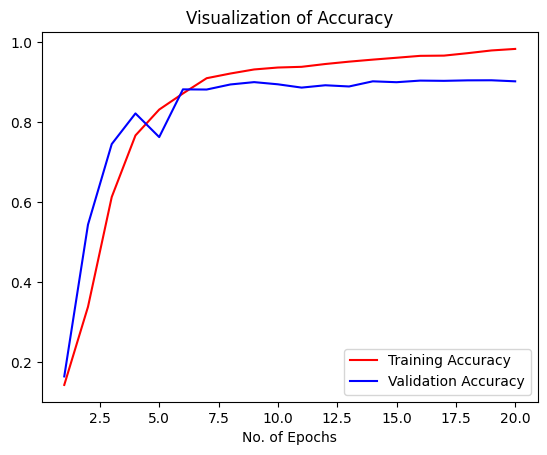

In [74]:
plot_accuracy(Epochs+1, lstm_training_history)

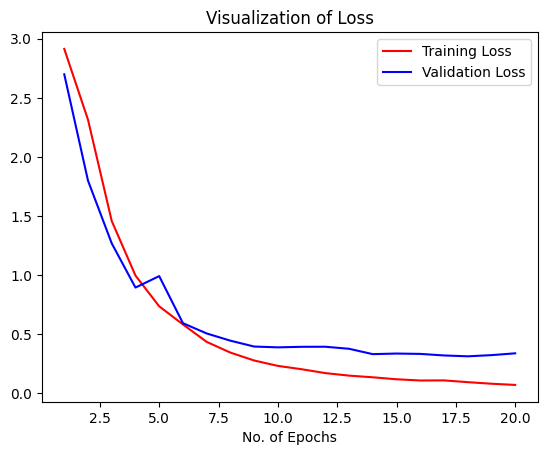

In [75]:
plot_loss(Epochs+1, lstm_training_history)

In [76]:
plot_classification_report(lstm_model, X_test, y_test, model_name="LSTM")

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
                Classification Report of LSTM Model
               precision    recall  f1-score   support

      Arabic       0.99      0.95      0.97       210
     Chinese       0.49      0.60      0.54       194
       Dutch       0.98      0.98      0.98       203
     English       0.89      0.86      0.88       197
    Estonian       0.87      0.94      0.90       200
      French       0.95      0.97      0.96       201
       Greek       0.99      0.95      0.97       200
       Hindi       0.99      0.97      0.98       196
  Indonesian       0.97      0.97      0.97       176
    Japanese       0.44      0.24      0.31       202
     Kannada       0.99      0.87      0.93       202
      Korean       0.95      0.94      0.95       198
       Latin       0.79      0.93      0.85       183
   Malayalam       0.72      0.88      0.79       213
     Persian       0.98      0.99      0.98       194
   Portugese       0.99      0.98      0.

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


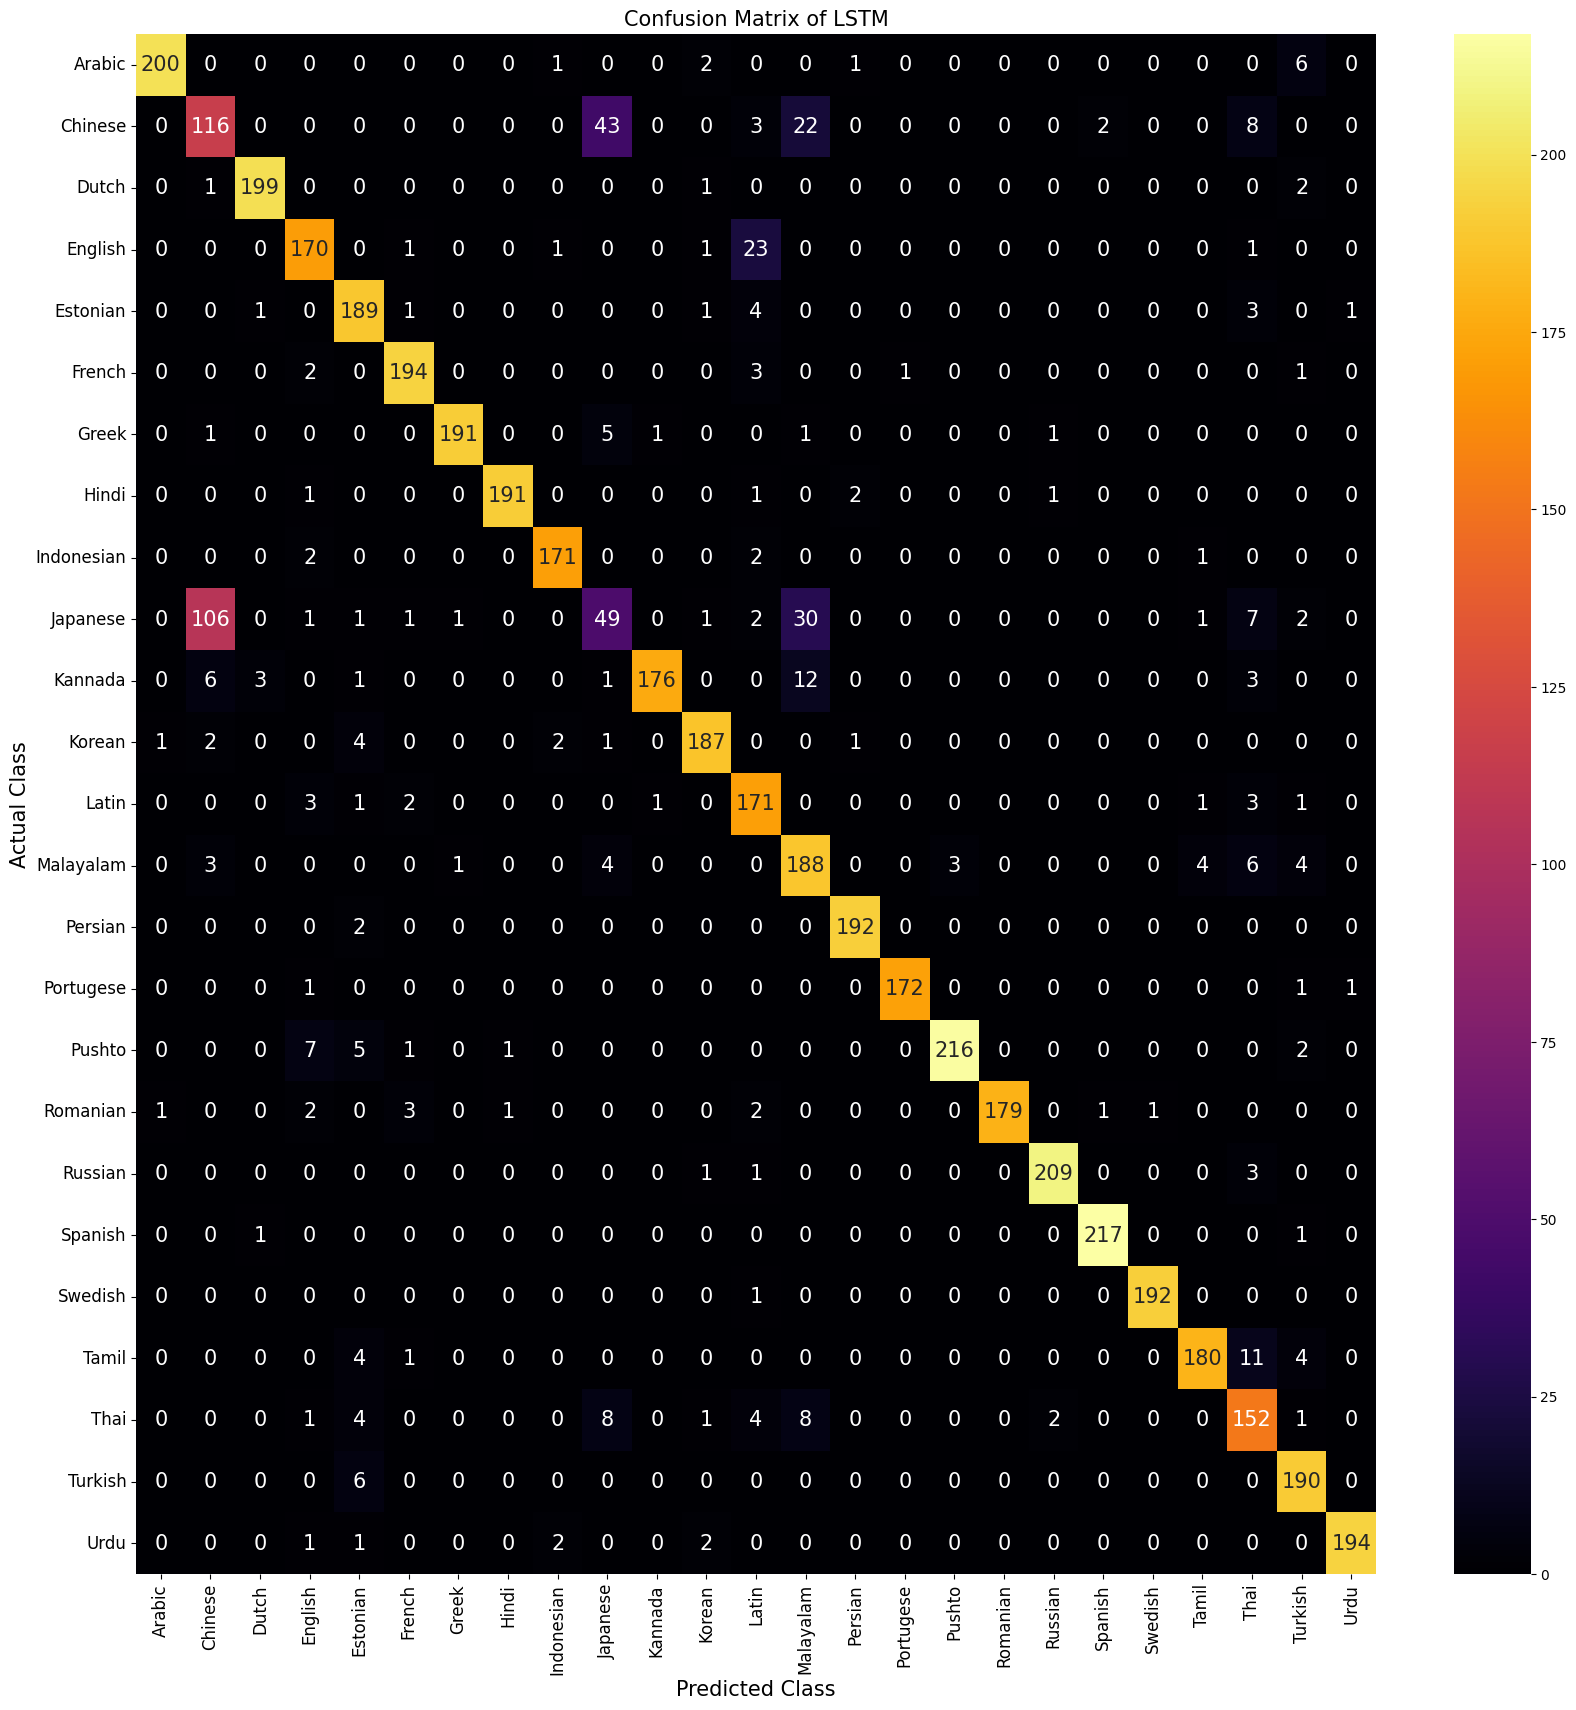

In [77]:
plot_confusion_matrix(lstm_model, X_test, y_test, model_name="LSTM")

In [78]:
model_save_path = "/kaggle/working/LC_LSTM_model.keras"
lstm_model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /kaggle/working/LC_LSTM_model.keras


In [ ]:
loaded_model = load_model("/kaggle/working/LC_LSTM_model.keras")
print("Model loaded successfully!")

In [81]:
#Recording History in json
with open('lstm_training_history.json','w') as f:
  json.dump(lstm_training_history.history,f)

In [ ]:
#Dictionary of history
# lstm_training_history.history 

In [ ]:
print(lstm_training_history.history.keys())

## GRU Model

In [82]:
gru_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, input_length=100),  
    GRU(units=64),
    Dropout(0.20),
    Dense(units=25, activation='softmax')
])

gru_model.build(input_shape=(None, 100))
optimizer = Adam(learning_rate=0.0001)
gru_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(gru_model.summary())

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ (None, 100, 100)            │      28,758,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 64)                  │          31,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 25)                  │           1,625 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,791,497 (109.83 MB)

 Trainable params: 28,791,497 (109.83 MB)

 Non-trainable params: 0 (0.00 B)

None


In [83]:
gru_training_history = gru_model.fit(X_train, y_train, epochs=Epochs, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
622/622 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.1191 - loss: 3.1073 - val_accuracy: 0.1348 - val_loss: 2.6678
Epoch 2/20
622/622 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.1792 - loss: 2.5829 - val_accuracy: 0.3278 - val_loss: 2.2962
Epoch 3/20
622/622 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.3263 - loss: 2.1505 - val_accuracy: 0.5516 - val_loss: 1.8460
Epoch 4/20
622/622 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.5379 - loss: 1.6345 - val_accuracy: 0.7505 - val_loss: 1.3208
Epoch 5/20
622/622 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.7736 - loss: 1.0586 - val_accuracy: 0.8136 - val_loss: 0.9371
Epoch 6/20
622/622 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.8688 - loss: 0.6767 - val_accuracy: 0.8404 - val_loss: 0.7482
Epoch 7/20
622/622 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.9171 - loss: 0.4730 - val_accuracy: 0.8497 - val_loss: 0.6415
Epoch 8/20
622/622 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.9394 - loss: 0.3371 - 

In [84]:
train_loss, train_acc = gru_model.evaluate(X_train,y_train)
print('Training Accuracy:', train_acc)
print("Training Loss:", train_loss)

622/622 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9992 - loss: 0.0089
Training Accuracy: 0.9994465708732605
Training Loss: 0.0081395348533988


In [85]:
val_loss, val_acc = gru_model.evaluate(X_test,y_test)
print('Validation Accuracy:', val_acc)
print("Validation Loss:", val_loss)

156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8783 - loss: 0.4525
Validation Accuracy: 0.874622642993927
Validation Loss: 0.46242764592170715


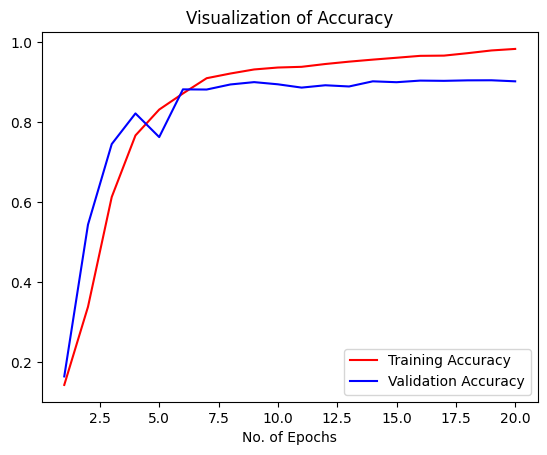

In [86]:
plot_accuracy(Epochs+1, gru_training_history)

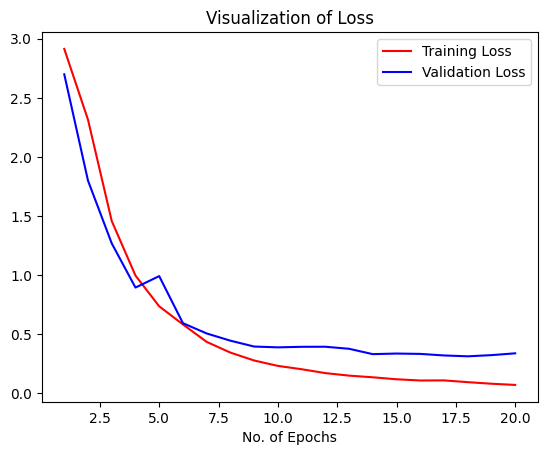

In [87]:
plot_loss(Epochs+1, gru_training_history)

In [88]:
plot_classification_report(gru_model, X_test, y_test, "GRU")

156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
                Classification Report of GRU Model
               precision    recall  f1-score   support

      Arabic       0.96      0.99      0.97       210
     Chinese       0.51      0.23      0.31       194
       Dutch       0.97      0.99      0.98       203
     English       0.89      0.84      0.86       197
    Estonian       0.86      0.92      0.88       200
      French       0.98      0.99      0.98       201
       Greek       0.96      0.96      0.96       200
       Hindi       0.97      0.98      0.98       196
  Indonesian       0.95      0.94      0.95       176
    Japanese       0.47      0.56      0.51       202
     Kannada       0.98      0.83      0.90       202
      Korean       0.88      0.92      0.90       198
       Latin       0.97      0.89      0.93       183
   Malayalam       0.64      0.86      0.73       213
     Persian       0.99      0.97      0.98       194
   Portugese       0.98      0.97      0.9

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


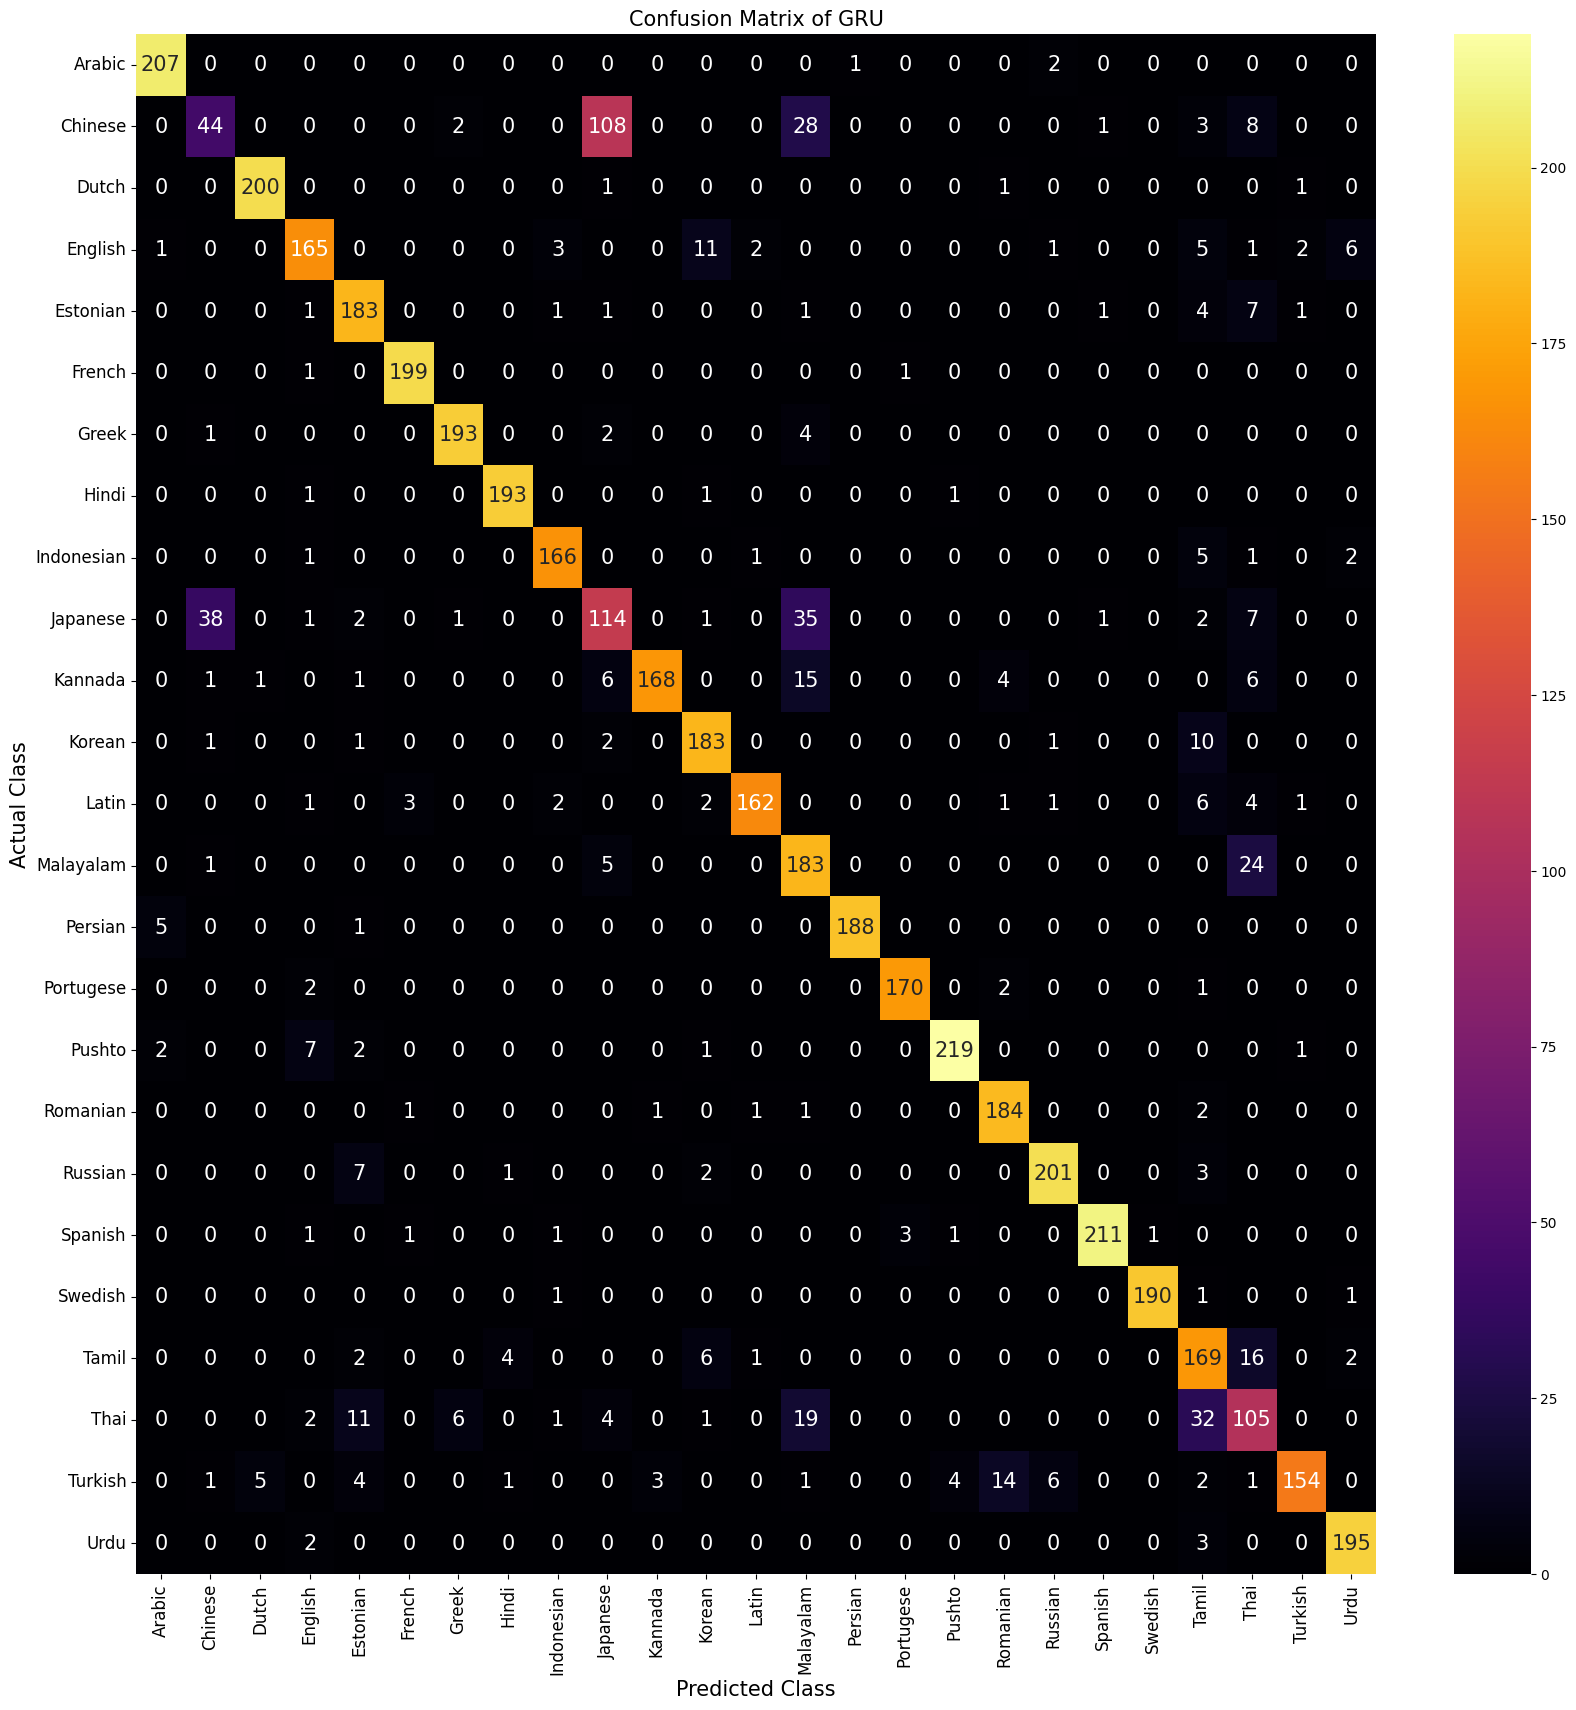

In [90]:
plot_confusion_matrix(gru_model, X_test, y_test, "GRU")

In [91]:
model_save_path = "/kaggle/working/LC_GRU_model.keras"
gru_model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /kaggle/working/LC_GRU_model.keras


In [ ]:
loaded_model = load_model("/kaggle/working/LC_GRU_model.keras")
print("Model loaded successfully!")

In [92]:
with open('gru_training_history.json','w') as f:
  json.dump(gru_training_history.history,f)

# CNN Training 

In [93]:
cnn_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, input_length=100),  
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(units=25, activation='softmax')
])

cnn_model.build(input_shape=(None, 100))
optimizer = Adam(learning_rate=0.0001)
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(cnn_model.summary())

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ (None, 100, 100)            │      28,758,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 96, 128)             │          64,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 25)                  │           3,225 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,825,353 (109.96 MB)

 Trainable params: 28,825,353 (109.96 MB)

 Non-trainable params: 0 (0.00 B)

None


In [94]:
cnn_training_history = cnn_model.fit(X_train, y_train, epochs=Epochs, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
622/622 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.5460 - loss: 1.8420 - val_accuracy: 0.9092 - val_loss: 0.2875
Epoch 2/20
622/622 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9489 - loss: 0.1530 - val_accuracy: 0.9276 - val_loss: 0.2159
Epoch 3/20
622/622 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9965 - loss: 0.0348 - val_accuracy: 0.9233 - val_loss: 0.2165
Epoch 4/20
622/622 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9994 - loss: 0.0044 - val_accuracy: 0.9292 - val_loss: 0.2095
Epoch 5/20
622/622 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9999 - loss: 0.0013 - val_accuracy: 0.9288 - val_loss: 0.2100
Epoch 6/20
622/622 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9999 - loss: 9.9693e-04 - val_accuracy: 0.9282 - val_loss: 0.2109
Epoch 7/20
622/622 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 1.0000 - loss: 4.2726e-04 - val_accuracy: 0.9298 - val_loss: 0.2103
Epoch 8/20
622/622 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 1.0000 - loss: 4.5538e-04 - va

In [95]:
train_loss, train_acc = cnn_model.evaluate(X_train,y_train)
print('Training Accuracy:', train_acc)
print("Training Loss:", train_loss)

622/622 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 2.1950e-06
Training Accuracy: 1.0
Training Loss: 2.0601860342139844e-06


In [96]:
val_loss, val_acc = cnn_model.evaluate(X_test,y_test)
print('Validation Accuracy:', val_acc)
print("Validation Loss:", val_loss)

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9264 - loss: 0.2506
Validation Accuracy: 0.9285570383071899
Validation Loss: 0.23800241947174072


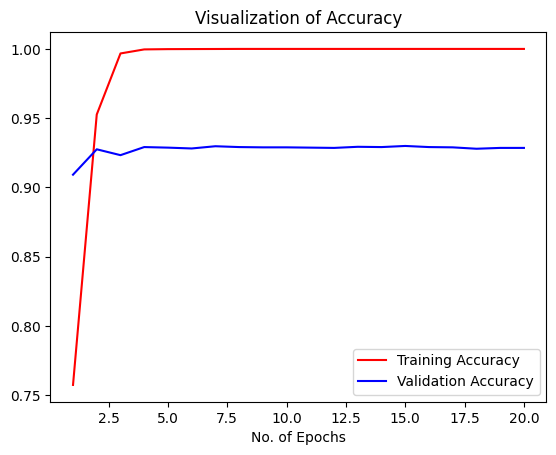

In [100]:
plot_accuracy(Epochs+1, cnn_training_history)

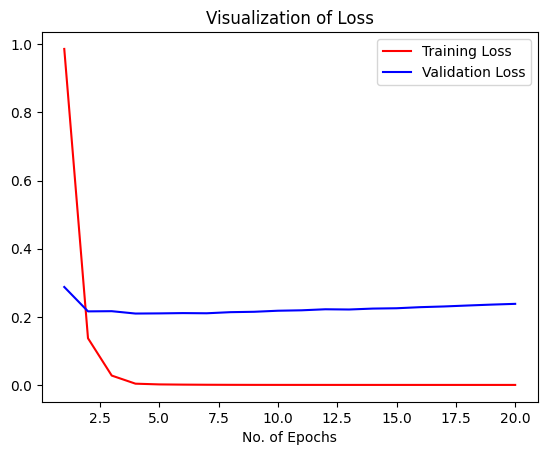

In [101]:
plot_loss(Epochs+1, cnn_training_history)

In [102]:
plot_classification_report(cnn_model, X_test, y_test, "CNN")

156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
                Classification Report of CNN Model
               precision    recall  f1-score   support

      Arabic       1.00      0.98      0.99       210
     Chinese       0.41      0.83      0.55       194
       Dutch       0.99      0.99      0.99       203
     English       0.89      0.99      0.94       197
    Estonian       0.97      0.95      0.96       200
      French       0.98      0.98      0.98       201
       Greek       1.00      0.95      0.98       200
       Hindi       1.00      0.99      0.99       196
  Indonesian       1.00      0.98      0.99       176
    Japanese       0.53      0.20      0.29       202
     Kannada       0.96      0.95      0.96       202
      Korean       1.00      0.96      0.98       198
       Latin       0.96      0.95      0.95       183
   Malayalam       0.98      0.89      0.93       213
     Persian       0.99      0.99      0.99       194
   Portugese       0.99      0.99      0.9

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


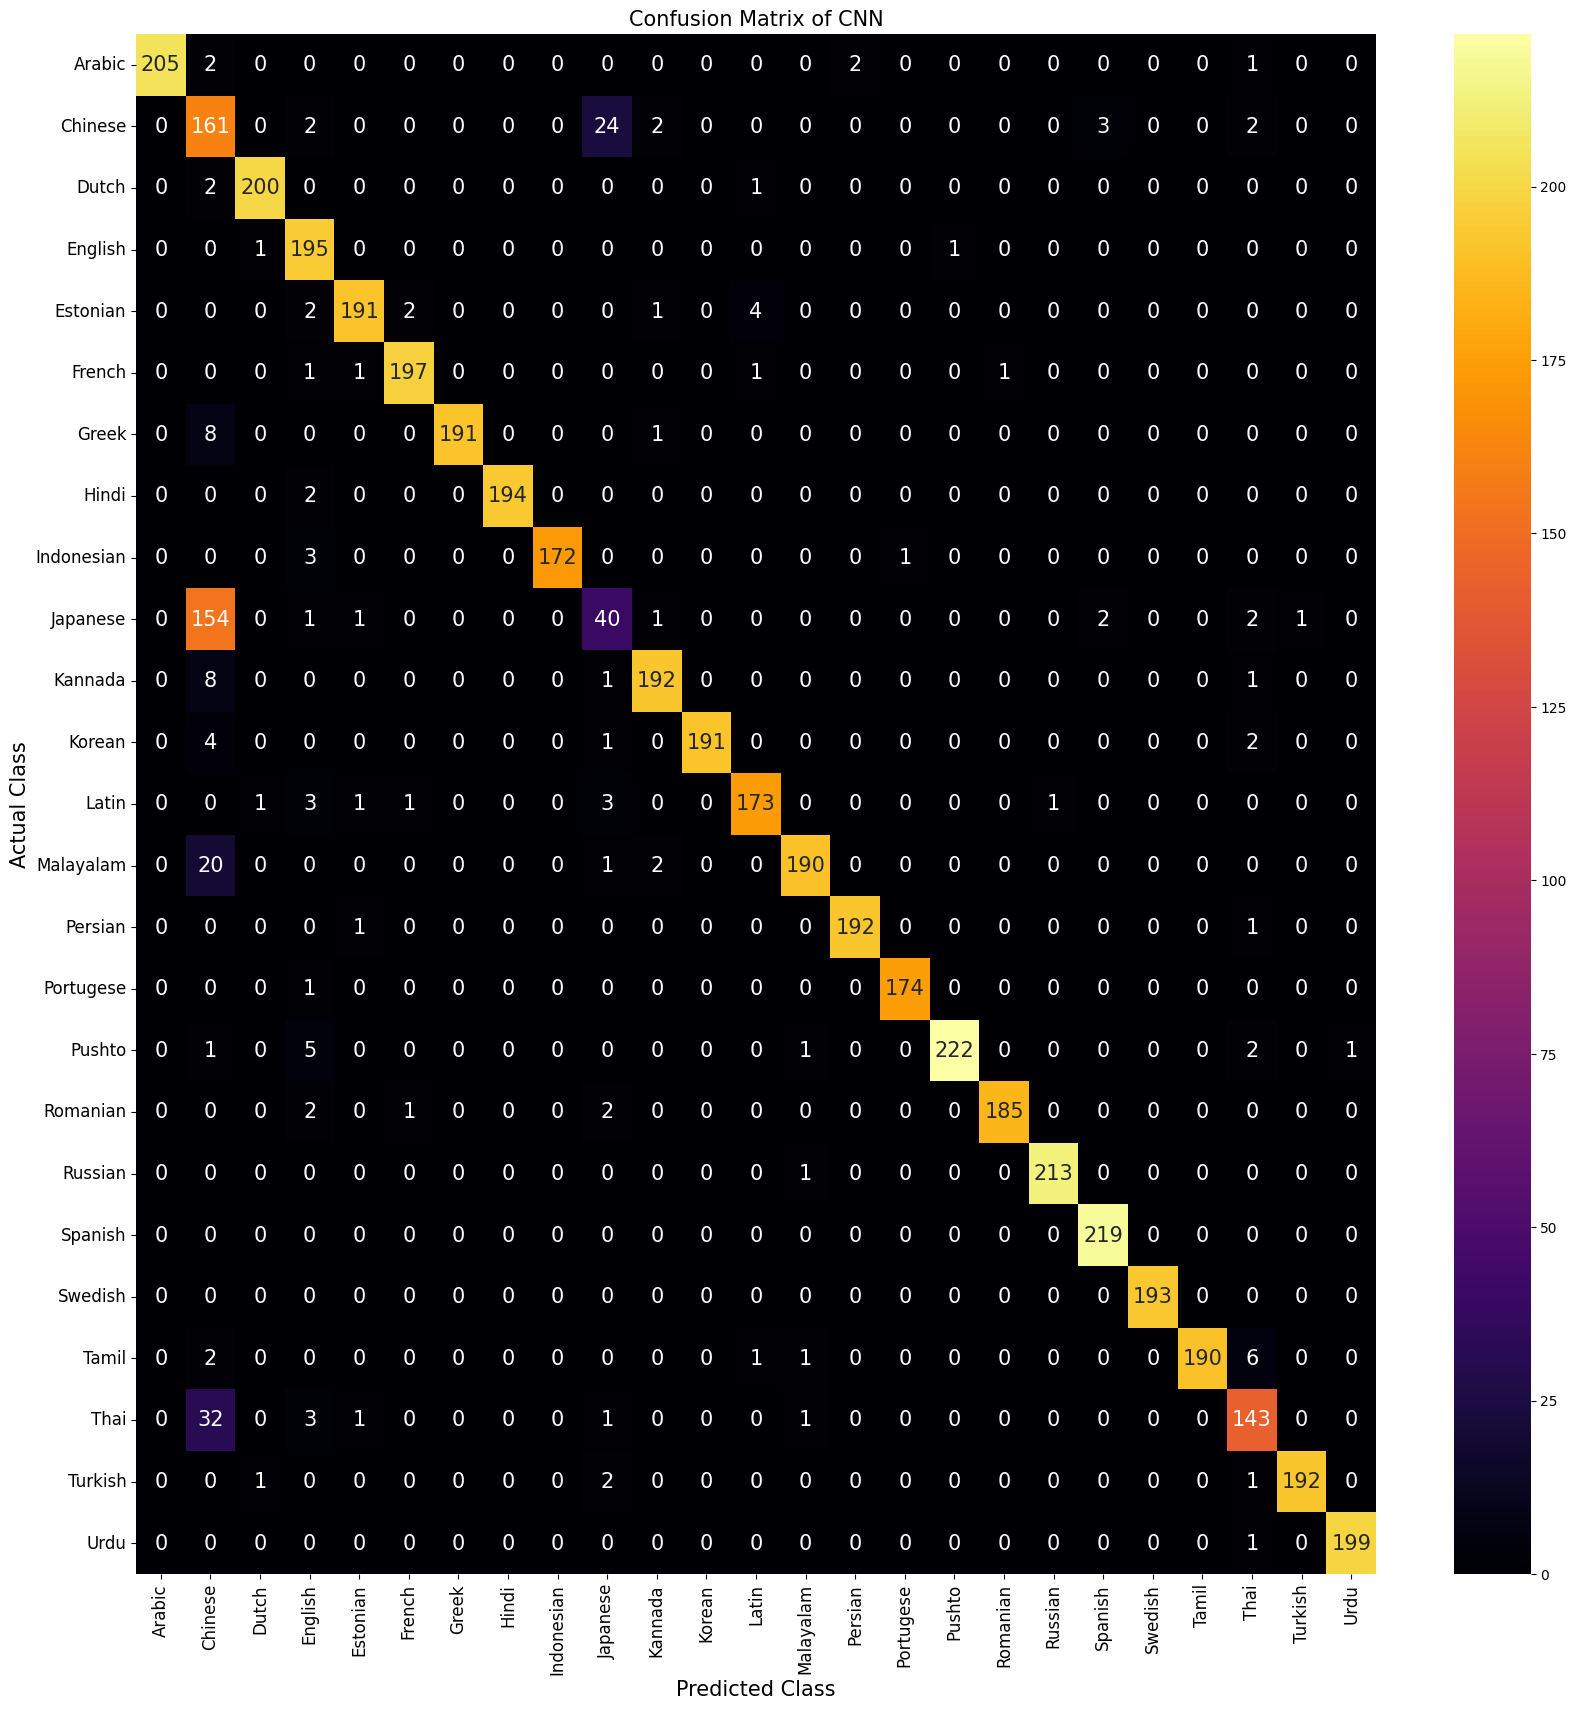

In [103]:
plot_confusion_matrix(cnn_model, X_test, y_test, "CNN")

In [104]:
model_save_path = "/kaggle/working/LC_CNN_model.keras"
cnn_model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /kaggle/working/LC_CNN_model.keras


In [ ]:
with open('CNN_training_history.json','w') as f:
  json.dump(lstm_training_history.history,f)

## Testing

In [106]:
def preprocess_input(text):
    sequences = tokenizer.texts_to_sequences([text])
    processed_text = pad_sequences(sequences, maxlen=100)
    return processed_text

def predict_language(model, text):
    processed_text = preprocess_input(text)
    predictions = model.predict(processed_text)
    return predictions

In [105]:
input_text = "जब सूर्य पश्चिम की ओर अपनी अंतिम किरणों के साथ गुड़ियाँ बुनने लगता है और संगीत की मिठास से भरी हवा में मिलने लगता है, तो भारत की प्राकृतिक सौंदर्य सचमुच अपनी महिमा में प्रकट होती है।"

In [107]:
predicted_language = predict_language(cnn_model, input_text)
print(predicted_language)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
[[5.6508553e-09 3.0670569e-18 6.4611830e-11 3.4241283e-14 7.7557755e-10
  1.5922156e-14 1.8131764e-17 1.0000000e+00 5.0953171e-09 2.2956816e-19
  8.9228063e-14 1.5009297e-10 3.0346705e-09 4.4187110e-14 6.7485698e-11
  8.8936686e-10 2.9552563e-12 7.0593867e-13 2.3766281e-11 1.1025045e-10
  3.3117269e-11 1.7979424e-08 2.4391516e-13 1.6913236e-10 2.8641498e-10]]


In [108]:
# Get the index of the class with the highest probability
predicted_index = np.argmax(predicted_language)

# Get the class name corresponding to the predicted index
predicted_class = class_names[predicted_index]

print("Predicted Language:", predicted_class)

Predicted Language: Hindi


## Sample Inputs

- Arabic: "الشمس تغرب والسماء تتلون بألوان الغروب، والنجوم تبدأ بالظهور في السماء المظلمة، وتنعم الطيور بالرقص في الهواء مع غروب الشمس وبداية الليل."

- Chinese: "夕阳西下，天空染上了晚霞的色彩，星星开始在黑暗的天空中闪烁，鸟儿随着夕阳的落下而在空中翩翩起舞，夜晚开始降临，大自然展现出它独特的美丽景色。"

- Japanese: "夕日が沈むと、空は夕焼け色に染まり、星々が暗闇の中に輝き始めます。鳥たちは夕日と夜の訪れに合わせて空中で踊り始め、夜が訪れると、自然はその独特の美しい景色を見せてくれます。"

- Dutch: "De zon gaat onder en kleurt de lucht met de kleuren van de ondergaande zon, terwijl de sterren beginnen te fonkelen in de donkere hemel. De vogels dansen in de lucht bij zonsondergang en het begin van de nacht, en de natuur toont zijn unieke en prachtige landschappen."

- English: "The sun sets, painting the sky with the colors of the setting sun, while the stars begin to twinkle in the dark sky. The birds dance in the air with the sunset and the onset of night, and nature displays its unique and beautiful landscapes."

- french - "La lueur du soleil couchant baignait le paysage d'une douce lumière dorée, illuminant les champs verdoyants et les collines ondoyantes, tandis que les oiseaux chantaient en chœur leur mélodie harmonieuse, créant ainsi une symphonie naturelle qui emplissait l'air de joie et de tranquillité."

- Estonian: Kui õhtu saabub Eestis ja päike hakkab looja, valgustavad taevas olevad tähesäras ja kuma järvede peegeldustes kogu looduse rahu ja ilu, mis võib leida ainult selles kaunis Baltimaade riigis.

- Greek: Καθώς η νύχτα πέφτει σιγά στην Ελλάδα και τα αστέρια αρχίζουν να λάμπουν στον ουρανό, ο αέρας γεμίζει με τη μυρωδιά των ελιών και των ανθέων, δημιουργώντας ένα αίσθημα ειρήνης και γαλήνης που είναι μοναδικό στην όμορφη χώρα της Μεσογείου.

- Hindi: जब सूर्य पश्चिम की ओर अपनी अंतिम किरणों के साथ गुड़ियाँ बुनने लगता है और संगीत की मिठास से भरी हवा में मिलने लगता है, तो भारत की प्राकृतिक सौंदर्य सचमुच अपनी महिमा में प्रकट होती है।

- Indonesian: Ketika senja menyapa Indonesia dan warna-warni langit mulai memudar, serta aroma rempah-rempah yang khas terbawa angin sejuk pegunungan, maka keindahan alam Indonesia yang memikat menjadi nyata dan mempesona, memberikan kedamaian yang hanya bisa ditemukan di negeri ini.

- Kannada: ಸೂರ್ಯನು ಪಶ್ಚಿಮಕ್ಕೆ ವಾಸುದೇವನಿಗೆ ಕೊಟ್ಟ ಅಂತಿಮ ಕಿರಣಗಳೊಡನೆ ಮುಳುಗುತ್ತಿದ್ದಾನೆ ಮತ್ತು ಗಿಡಮರಗಳ ಮಧುರ ಪರಿಮಳವು ಹಿಮಾಲಯದ ಶೀತದ ಗಾಳಿಯಲ್ಲಿ ಸಂಗೀತವನ್ನು ಹೊರಗೆಡಹುತ್ತದೆ, ಆಗ ಭಾರತದ ಪ್ರಾಕೃತಿಕ ಸೌಂದರ್ಯವು ತನ್ನ ಪ್ರಕಾಶದಲ್ಲಿ ಪ್ರಕಟವಾಗುತ್ತದೆ, ಅದು ಈ ದೇಶದಲ್ಲಿ ಮಾತ್ರ ಕಂಡು ಬರುವ ಶಾಂತಿಯನ್ನು ನೀಡುತ್ತದೆ.

- Korean: 저녁이 한국에 도래하고 태양이 서쪽으로 가장한 후, 하늘의 별들이 반짝이며 산들에서 바람이 실은 소나무와 장미의 향기가 섞이며, 한국의 자연 아름다움이 고요함과 아름다움을 더하여 보여줍니다.

- Latin: Cum vesper in terris advenit et sol occidentem versus ultimos radios emittit, coeli sidera micant et aura aromatum suaviumque ex floribus viridariis montium vehitur, tunc pulchritudo naturalis in regione hac manifesta est, pacem et beatitudinem tantum in hac terra reperiendam.

- Malayalam: സൂര്യന്‍ പടിഞ്ഞാറേ സമയം സന്ദർശിക്കുന്നതും നിശാന്ധതയും കൂടുതൽ ആഴമുള്ള വാതകളുടെ മധുര മിശ്രണമുള്ള ഹിമാലയത്തിന്റെ ജലോത്ഭവ അരിയും ആരോഗ്യത്തിന്റെ ശീതല മലനിരപ്പിന്റെ ഗായനമുള്ളതും ഭാരതത്തിന്റെ സ്വാഭാവിക സൗന്ദര്യം തന്നെ തോന്നുന്നു.

- Persian: زمانی که غروب در ایران فرا می‌رسد و خورشید آخرین اشعه‌های خود را به سمت غرب فرستاده و ستارگان آسمان می‌درخشند و بادی که با خاصیت‌های خاص خود از بوی گل‌های باغ‌های کوهستانی برخاسته، انسان را به شگفتی‌های طبیعت ایران می‌کشاند و آرامشی را فرا می‌هماند که تنها در این سرزمین می‌توان یافت.

- Portuguese: Quando o crepúsculo chega a Portugal e o sol envia seus últimos raios na direção oeste, as estrelas do céu brilham e o vento traz consigo o aroma suave das flores dos jardins das montanhas, então a beleza natural deste país se revela, proporcionando uma paz e uma felicidade que só aqui podem ser encontradas.

- Pashto: کله زړه په افغانستان کې راته پېژندی او سورې د خپلو اخري لمونو رښتياوو کې لږ مېرمن شي او هوا په هغه خاصو خواړو کې څوک د ښکاري څېرمهوتونو او په کوهستانو کې باغونو ګلابونو د پيښې او خوشبو د يو اشپزخانې په خلكو په اړه ساتل او په همدې رنځه کې سلامتي د وطني ښکاري، په همدې آغاز او بښور يې پيدا کوي.

- Romanian: Când crepusculul coboară în România și soarele își trimite ultimele raze spre apus, stelele cerului strălucesc și vântul aduce cu el aroma dulce a florilor din grădinile munților, atunci frumusețea naturală a acestei țări se dezvăluie, oferind o pace și o fericire care pot fi găsite doar aici.

- Russian: Когда сумерки наступают в России и солнце посылает свои последние лучи к западу, звезды на небе сверкают, а ветер несет с собой сладкий аромат цветов с горных садов, тогда природная красота этой страны раскрывается, принося спокойствие и счастье, которые можно найти только здесь.

- Spanish: Cuando el crepúsculo llega a España y el sol envía sus últimos rayos hacia el oeste, las estrellas en el cielo brillan y el viento trae consigo el dulce aroma de las flores de los jardines de montaña, entonces la belleza natural de este país se revela, brindando una paz y una felicidad que solo aquí pueden encontrarse.

- Swedish: När skymningen faller över Sverige och solen sänder sina sista strålar mot väster, glittrar stjärnorna på himlen och vinden för med sig doften av blommorna från bergsträdgårdarna, då visar sig den naturliga skönheten i detta land, och ger en frid och lycka som bara här kan upplevas.

- Tamil: இந்தியாவில் இருந்து மூடியதும் மறைந்ததும் சூரியன் தென்புலத்திற்கு தனது கடைசி கற்பனைகளை அனுப்புகின்றது போல தாராளமான அம்புகள் வானத்தில் வளரும்; பர்வதம் பூக்களில் நிறைந்த மணம் கரையில் கரையும் காற்று கொண்டு, பேரின்பமும் சந்தோஷமும் தேடும் குடியில் பிரகடமாக அமைந்து கொள்ளும்.

- Thai: เมื่อค่ำคืนมาถึงประเทศไทยและพระอาทิตย์ส่งแสงสุดท้ายของตนไปทางตะวันตก, ดวงดาวบนฟ้าระยิบระยับและลมพากลิ่นหอมของดอกไม้จากสวนเขา, ความสวยงามของธรรมชาติในประเทศนี้จึงเปิดเผยตัวเอง, ทำให้มีความสงบสุขที่มีได้แค่ที่นี่เท่านั้น.

- Turkish: Akşam üstü Türkiye'ye vardığında ve güneş batıya doğru son ışıklarını gönderdiğinde, gökyüzündeki yıldızlar parıldar ve rüzgar dağ bahçelerinin çiçeklerinin tatlı kokusunu getirir, işte o zaman bu ülkenin doğal güzelliği ortaya çıkar ve sadece burada bulunabilen bir huzur ve mutluluk sağlar.

- Urdu: جب شام آفتاب پاکستان میں آتی ہے اور سورج مغرب کی طرف اپنی آخری کرنوں کو بھیجتا ہے، تو آسمان میں ستارے چمکتے ہیں اور ہوا کوہستانی باغات کے پھولوں کی مہک لاتی ہے، تب یہ ملک کی قدرتی خوبصورتی سامنے آتی ہے، صرف یہاں پر ملنے والی ایک پرامنی اور خوشی پیدا کرتی ہے۔